In [350]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ds803/course_project_train.csv
/kaggle/input/ds803/course_project_test.csv


In [351]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Обзор данных

#### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Пути к директориям и файлам

In [352]:
TRAIN_DATASET_PATH = '../input/ds803/course_project_train.csv'
TEST_DATASET_PATH = '../input/ds803/course_project_test.csv'

#### Загрузка данных

In [353]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [354]:
df_train.shape

(7500, 17)

In [355]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [356]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Анализ целевой переменной

In [357]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

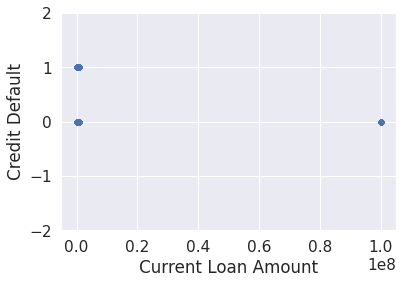

In [358]:
var = 'Current Loan Amount'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

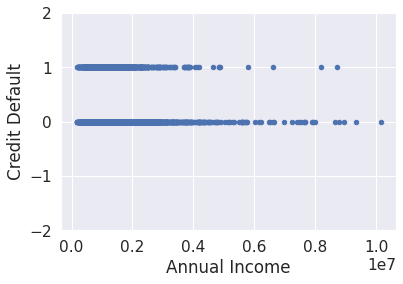

In [359]:
var = 'Annual Income'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

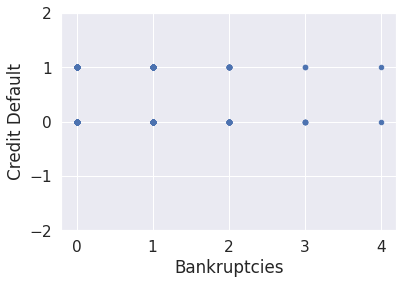

In [360]:
var = 'Bankruptcies'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

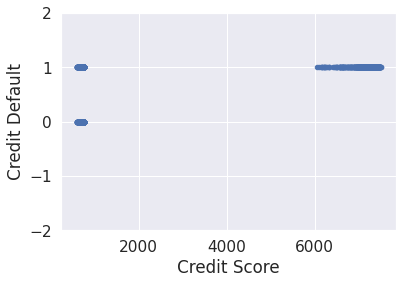

In [361]:
var = 'Credit Score'
data = pd.concat([df_train['Credit Default'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Credit Default', ylim=(-2,2));

#### Выделение целевой переменной и групп признаков

In [362]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

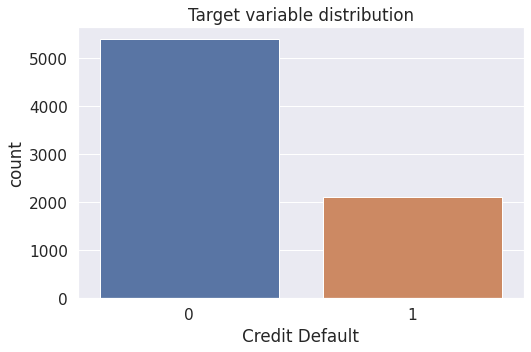

In [363]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками

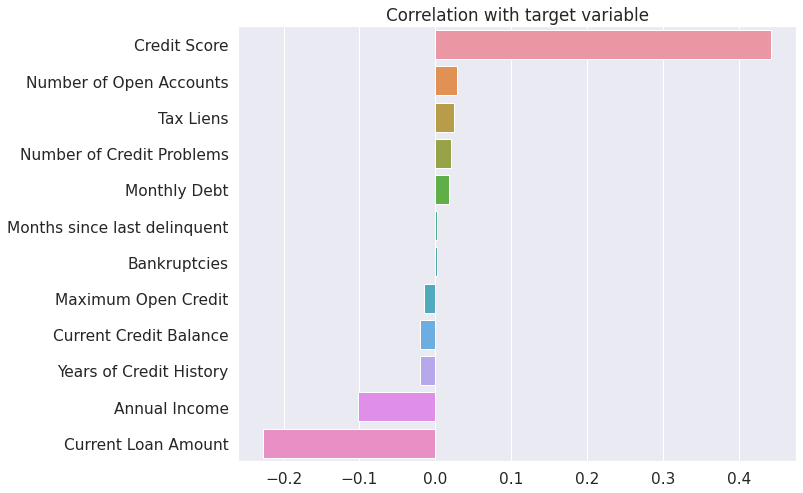

In [364]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства
#### Матрица корреляций

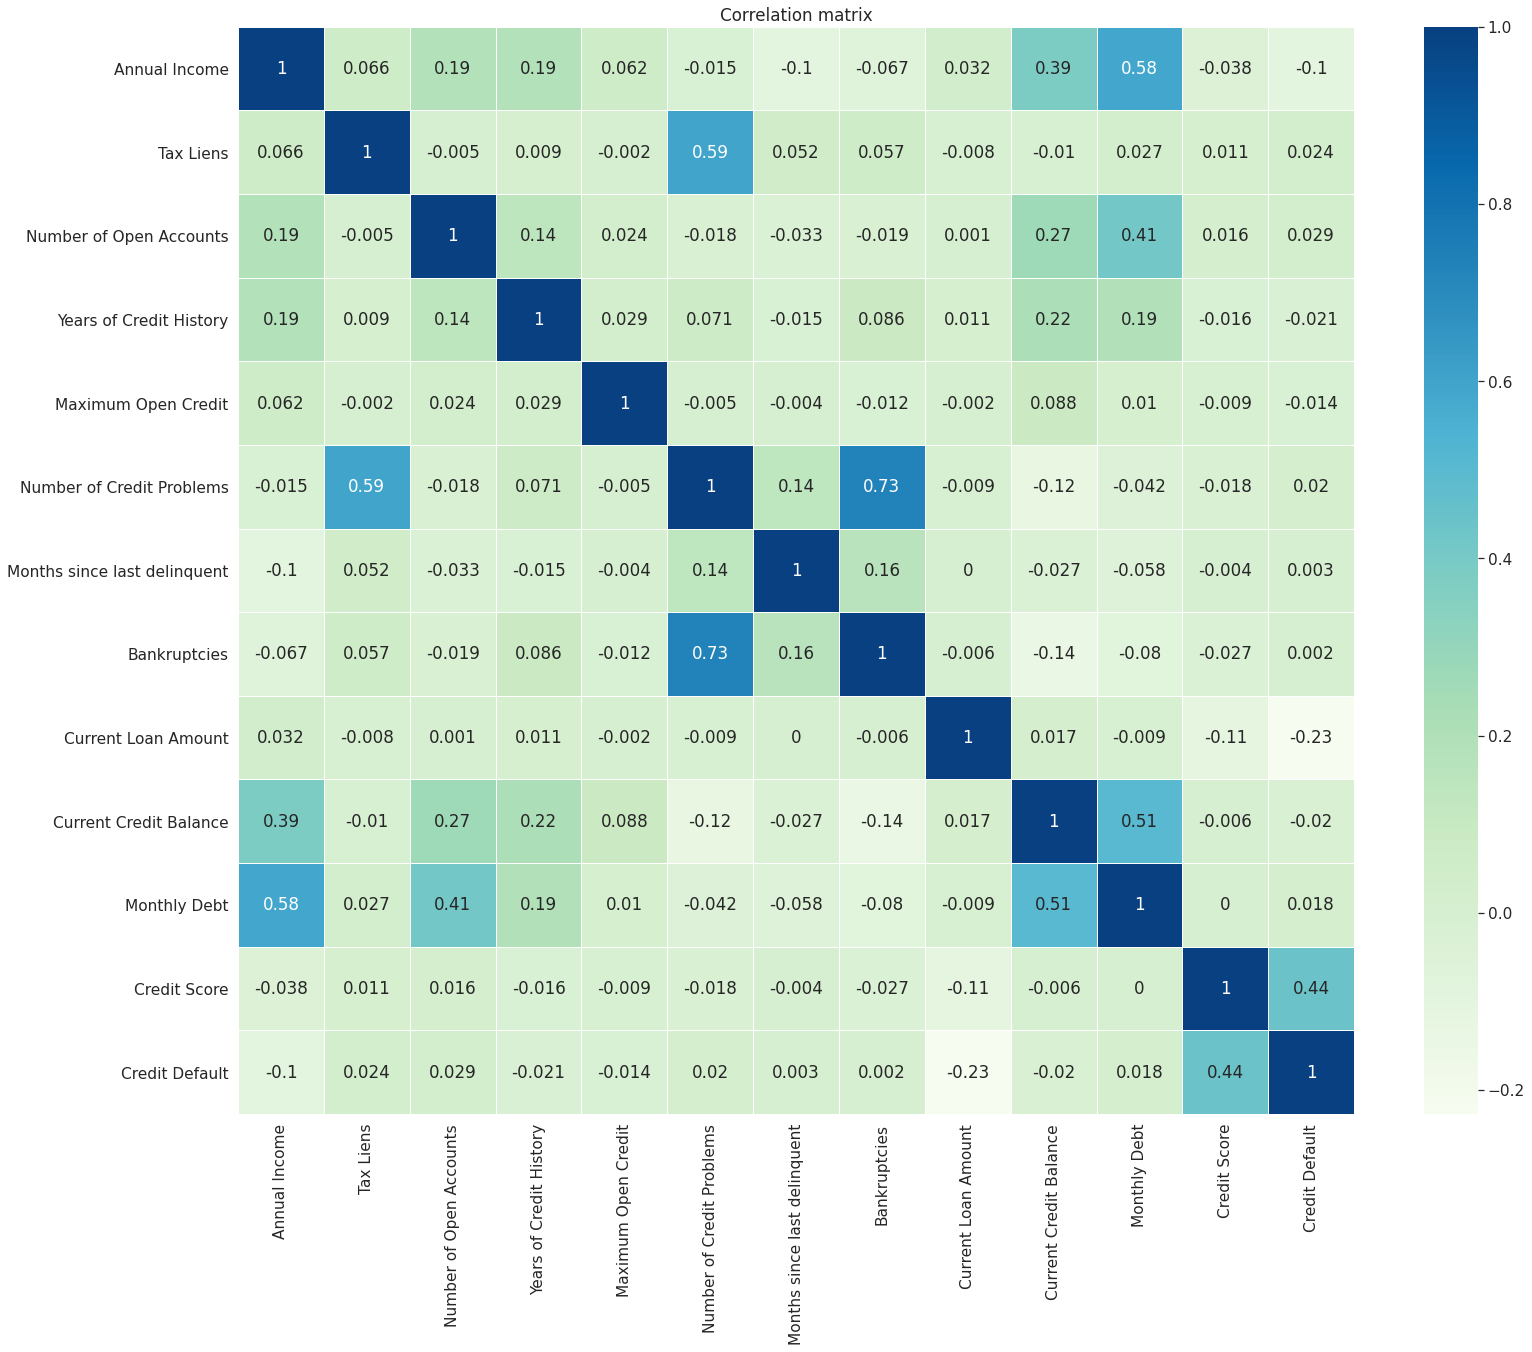

In [365]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Обработка выбросов и пропусков

In [366]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        self.medians = None
        self.binary_to_numbers = None        
        
    def fit(self, X):
        self.medians = X.median()
        # Binary features
        self.binary_to_numbers = {'Short Term': 0, 'Long Term': 1}        
    
    def transform(self, X):
        
        X = pd.get_dummies(X, prefix=['Purpose','Home'],columns=['Purpose','Home Ownership'])
        
        X['Years in current job'].fillna(0, inplace=True)
        
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = 0
        X.loc[X['Years in current job'] == '1 year', 'Years in current job'] = 1
        X.loc[X['Years in current job'] == '2 years', 'Years in current job'] = 2
        X.loc[X['Years in current job'] == '3 years', 'Years in current job'] = 3
        X.loc[X['Years in current job'] == '4 years', 'Years in current job'] = 4
        X.loc[X['Years in current job'] == '5 years', 'Years in current job'] = 5
        X.loc[X['Years in current job'] == '6 years', 'Years in current job'] = 6
        X.loc[X['Years in current job'] == '7 years', 'Years in current job'] = 7
        X.loc[X['Years in current job'] == '8 years', 'Years in current job'] = 8
        X.loc[X['Years in current job'] == '9 years', 'Years in current job'] = 9
        X.loc[X['Years in current job'] == '10+ years', 'Years in current job'] = 10
        X['Years in current job'] = X['Years in current job'].apply(pd.to_numeric, errors='coerce')
        
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        X['Bankruptcies'].fillna(self.medians['Bankruptcies'], inplace=True)
        X['Months since last delinquent'].fillna(0, inplace=True)
        X.loc[X['Current Loan Amount'] > 1000000, 'Current Loan Amount'] = self.medians['Current Loan Amount']        
        
        X['Term'] = X['Term'].map(self.binary_to_numbers)

        return X

#### Обработка матрицы

In [367]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)
df_train = preprocessor.transform(df_train)

### Анализ обработанной матрицы

##### Выделение целевой переменной и групп признаков

In [368]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

##### Корреляция с базовыми признаками

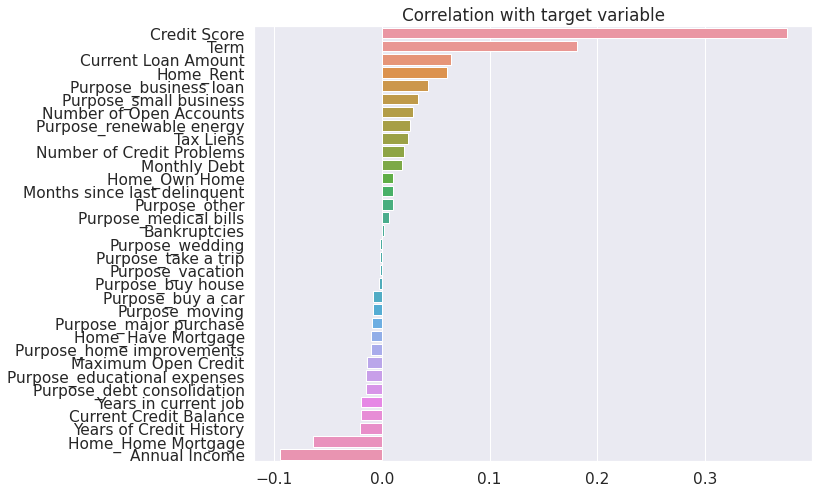

In [369]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Матрица корреляций

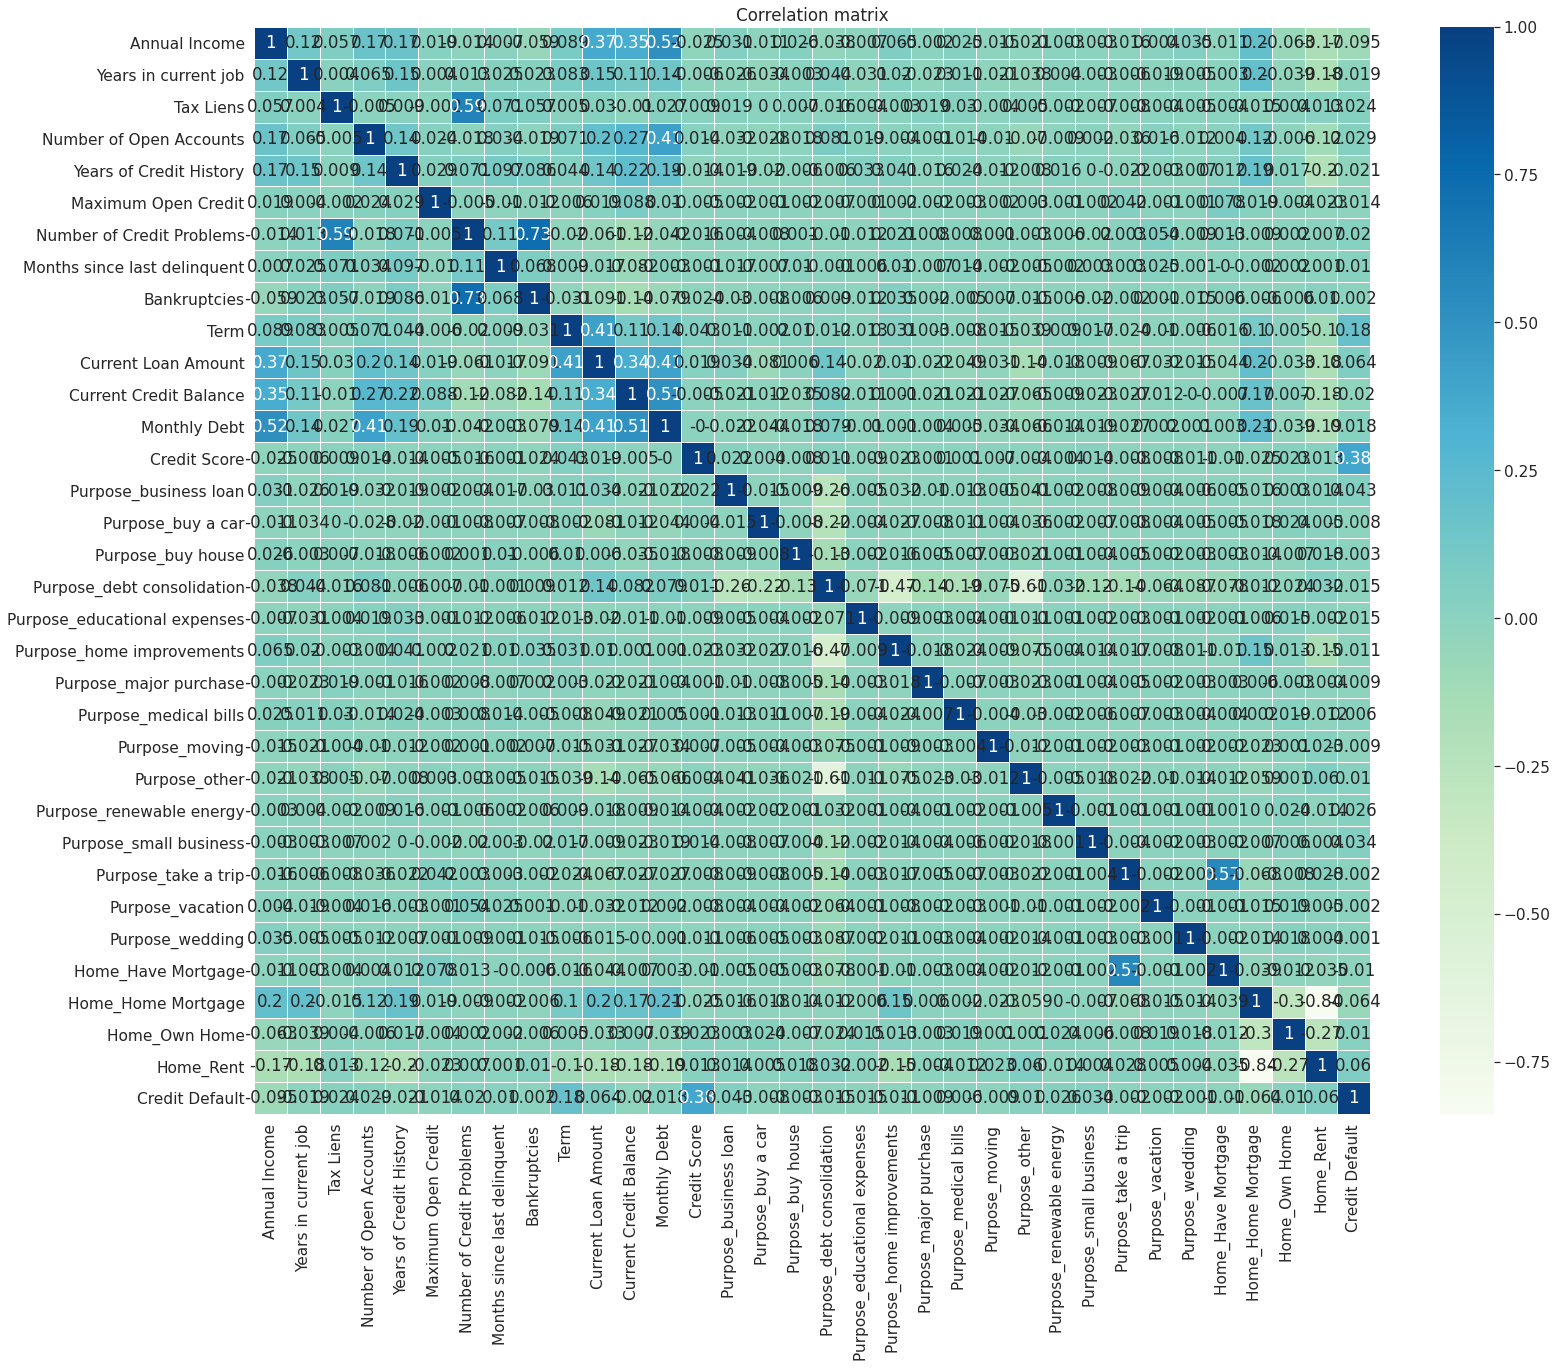

In [370]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

#### Отбор признаков

In [371]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Years in current job          7500 non-null   int64  
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Term                          7500 non-null   int64  
 10  Current Loan Amount           7500 non-null   float64
 11  Current Credit Balance        7500 non-null   float64
 12  Monthly Debt                  7500 non-null   float64
 13  Cre

#### Выделение признакового описания и целевой переменной

In [372]:
NUMERIC_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                         'Number of Credit Problems', 'Years of Credit History',
                        'Maximum Open Credit', 'Current Loan Amount', 'Months since last delinquent',
                         'Current Credit Balance', 'Bankruptcies','Monthly Debt', 'Credit Score']
BIN_FEATURE_NAMES = ['Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation', 'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase', 'Purpose_medical bills',
                    'Purpose_moving', 'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding', 
                     'Home_Have Mortgage', 'Home_Home Mortgage', 'Home_Own Home', 'Home_Rent', 'Term']

### Разбиение на train и test

In [373]:
X_train = df_train[NUMERIC_FEATURE_NAMES + BIN_FEATURE_NAMES]
y_train = df_train[TARGET_NAME]

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, test_size=0.25, random_state=211)

### Выбор лучшей модели и подбор гиперпараметров

##### Скрипты для проверки модели

In [375]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [376]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [377]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [378]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

##### Модель CatBoostClassifier

In [379]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      4047
           1       0.99      0.54      0.70      1578

    accuracy                           0.87      5625
   macro avg       0.92      0.77      0.81      5625
weighted avg       0.89      0.87      0.86      5625

TEST

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1340
           1       0.78      0.31      0.44       535

    accuracy                           0.78      1875
   macro avg       0.78      0.64      0.65      1875
weighted avg       0.78      0.78      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1294   46
1                369  166


### Подбор признаков

##### Подбор оптимального размера выборки, кривая обучения

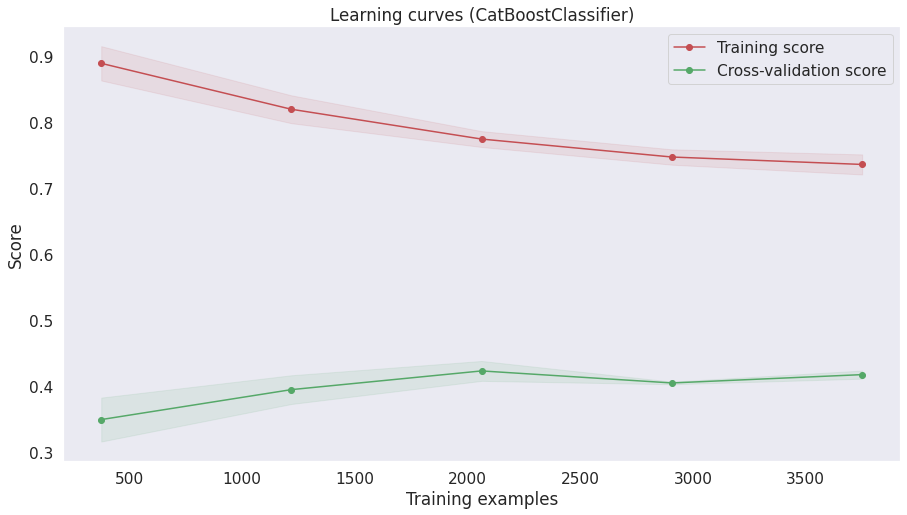

In [380]:
show_learning_curve_plot(model_catb, X_train, y_train)

##### Выбор порога вероятности для определения класса

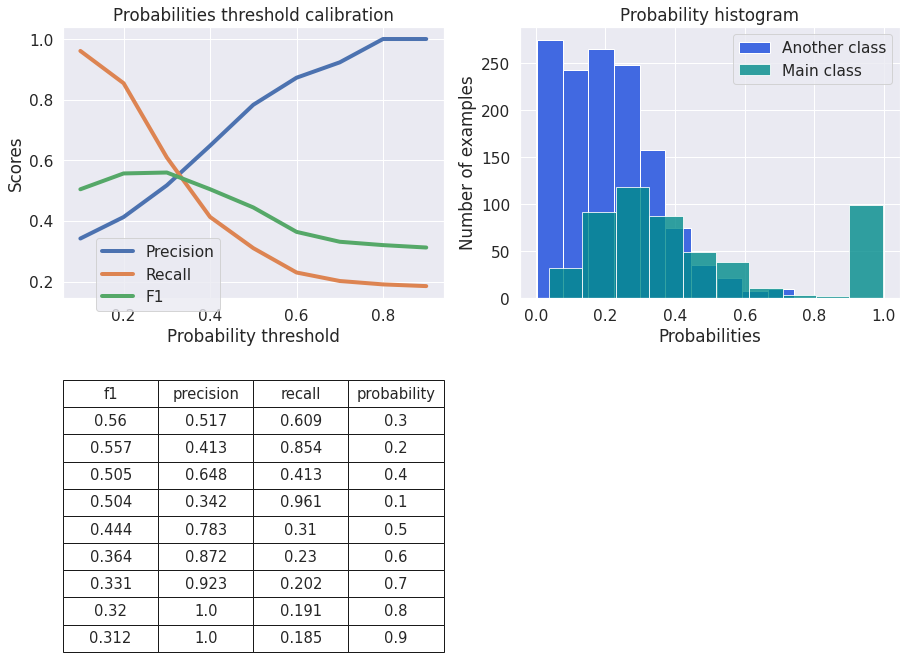

In [381]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

##### Важность признаков

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


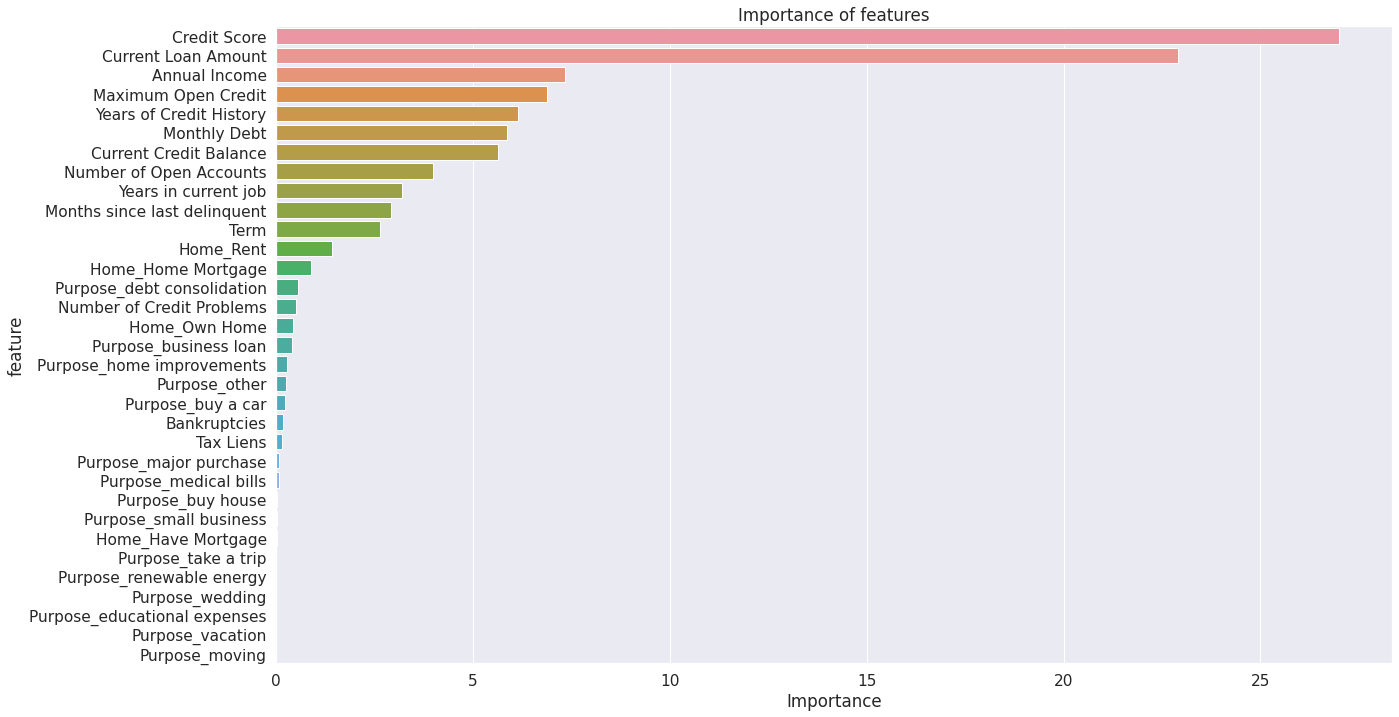

In [382]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [383]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job',
 'Months since last delinquent',
 'Term',
 'Home_Rent',
 'Home_Home Mortgage',
 'Purpose_debt consolidation',
 'Number of Credit Problems']

In [384]:
NUMERIC_FEATURE_NAMES = ['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Months since last delinquent']

BIN_FEATURE_NAMES = ['Current Credit Balance',
 'Number of Open Accounts',
 'Years in current job',
 'Term',
 'Home_Rent',
 'Home_Home Mortgage',
 'Purpose_debt consolidation',
 'Number of Credit Problems']

#### Разбиение на train и test

In [385]:
X = df_train[important_features_top]
y = df_train[TARGET_NAME]

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

#### Подбор параметров

In [387]:
params = {
    'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
    'max_depth':[3, 5, 7],
    'random_state':[50, 100, 200],
    'early_stopping_rounds':[10, 20, 30],
    'l2_leaf_reg':[8, 10, 12]
         }

In [388]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [389]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 16.1 s, sys: 1.61 s, total: 17.8 s
Wall time: 1min 32s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f49a5a60fd0>,
                   n_jobs=-1,
                   param_distributions={'early_stopping_rounds': [10, 20, 30],
                                        'l2_leaf_reg': [8, 10, 12],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500],
                                        'random_state': [50, 100, 200]},
                   scoring='f1')

In [390]:
rs.best_params_

{'random_state': 50,
 'n_estimators': 1200,
 'max_depth': 7,
 'l2_leaf_reg': 12,
 'early_stopping_rounds': 20}

In [391]:
rs.best_score_

0.44558454344870596

## Финальная модель

#### Параметры

In [392]:
frozen_params = {
    'class_weights':[1, 2.3],
    'n_estimators': 420,
    'max_depth': 3,
    'silent':True,
    'random_state':50,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'l2_leaf_reg':10
}

#### Обучение модели

In [393]:
final_model = catb.CatBoostClassifier(**frozen_params)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)


get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      4047
           1       0.55      0.64      0.59      1578

    accuracy                           0.75      5625
   macro avg       0.70      0.72      0.71      5625
weighted avg       0.77      0.75      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1340
           1       0.52      0.62      0.57       535

    accuracy                           0.73      1875
   macro avg       0.68      0.70      0.69      1875
weighted avg       0.75      0.73      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1038  302
1                202  333


### Прогноз

#### Загрузка тестовых данных

In [394]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [395]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [396]:
preprocessor = DataPreprocessing()
preprocessor.fit(df_test)
df_test = preprocessor.transform(df_test)

In [397]:
df_test = df_test[important_features_top]

#### Предсказание

In [398]:
y_test_pred = final_model.predict(df_test)

In [399]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['Credit Default'])
y_test_pred

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,1
2498,0


In [400]:
y_test_pred.to_csv('OSidorov_predictions.csv', index=True, index_label='Id', encoding='utf-8')